In [1]:
# !pip install fastjet

In [1]:
import glob
import os
import sys

sys.path.insert(0, "hbb_interaction_network")

import pickle as pkl
import time
from itertools import cycle

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch_geometric
from sklearn.metrics import auc, roc_curve
from torch_geometric.data import Batch, Data
from torch_geometric.loader import DataListLoader, DataLoader

import awkward as ak
import fastjet
import vector

plt.style.use(hep.style.CMS)
plt.rcParams.update({"font.size": 20})

from tqdm.notebook import tqdm

In [2]:
# define the global base device
world_size = torch.cuda.device_count()
multi_gpu = world_size >= 2
if world_size:
    device = torch.device("cuda:0")
    for i in range(world_size):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
else:
    device = "cpu"
    print("Device: CPU")

Device 0: NVIDIA GeForce RTX 2080 Ti


In [4]:
! ls /../ssl-jet-vol-v2/toptagging/*/processed

/../ssl-jet-vol-v2/toptagging/test/processed:
data_0.pt  data_1.pt  data_2.pt  data_3.pt  data_quick.pt

/../ssl-jet-vol-v2/toptagging/train/processed:
data_0.pt   data_11.pt	data_2.pt  data_4.pt  data_6.pt  data_8.pt
data_10.pt  data_1.pt	data_3.pt  data_5.pt  data_7.pt  data_9.pt

/../ssl-jet-vol-v2/toptagging/val/processed:
data_0.pt  data_1.pt  data_2.pt  data_3.pt


In [3]:
# load the datafiles
def load_data(dataset_path, flag, n_files=-1):
    data_files = glob.glob(f"{dataset_path}/{flag}/processed/*")
        
    data = []
    for i, file in enumerate(data_files):
        data += torch.load(f"{dataset_path}/{flag}/processed/data_{i}.pt")
        print(f"--- loaded file {i} from `{flag}` directory")
        if n_files!=-1 and i==n_files-1:
            break
                
    return data

dataset_path = "/../ssl-jet-vol-v2/toptagging/"

data_train = load_data(dataset_path, "train", n_files=1)
# data_valid = load_data(dataset_path, "val", n_files=4)
# data_test = load_data(dataset_path, "val", n_files=1)

--- loaded file 0 from `train` directory


In [6]:
len(data_train) / 1000

100.001

In [9]:
data_train[0]

Data(x=[23, 7], y=0)

In [10]:
"""
The 7 input features per particle in the jet.
    1. ∆η difference in pseudorapidity between the particle and the jet axis
    2. ∆φ difference in azimuthal angle between the particle and the jet axis
    3. log pT logarithm of the particle’s pT
    4. log E logarithm of the particle’s energy
    5. log pT/pT_jet logarithm of the particle’s pT relative to the jet pT
    6. log E/E_jet logarithm of the particle’s energy relative to the jet energy
    7. ∆R
"""

feature_dict = {
    "eta": 0,
    "phi": 1,
    "pt": 2,
    "E": 3,
    "pt/jet_pt": 4,
    "E/jet_E": 5,
    "deltaR": 6,    
}

feature_label = {
    "eta": r"Particle $\left| \eta \right|$",
    "phi": r"Particle $\left| \phi \right|$",
    "pt": r"Particle $p_T$",
    "E": "Particle E",
    "pt/jet_pt": r"Log($\frac{p_T(particle)}{p_T(jet)})$",
    "E/jet_E": r"$Log(\frac{E(particle)}{E(jet)})$",
    "deltaR": r"$\Delta R(particle, jet)$", 
    
}

In [11]:
num_features = 7

In [5]:
batch_size = 128

train_loader = DataLoader(data_train, batch_size)
# valid_loader = DataLoader(data_valid, batch_size)
# test_loader = DataLoader(data_test, batch_size)

In [6]:
train_loader

In [39]:
for i, bb in enumerate(train_loader):
    break

In [21]:
bb

DataBatch(x=[5980, 7], y=[128], batch=[5980], ptr=[129])

In [8]:
from src.models.jet_augs import *

In [10]:
collinear_fill_jets(bb, device)

DataBatch(x=[8909, 7], y=[128], batch=[8909], ptr=[129])

## Reshape a batch
Original shape: (n_constit_total, 7)  
Desired shape: (batch_size, 3, n_constit)

In [40]:
bb.x = bb.x[:, :3]

In [41]:
bb

DataBatch(x=[5980, 3], y=[128], batch=[5980], ptr=[129])

In [15]:
torch.bincount(bb.batch).max().item()

90

In [13]:
bb.x = bb.x.transpose(0,1)

In [14]:
bb.x.shape

torch.Size([3, 5980])

In [30]:
np.array(bb[i].x[:, :3].transpose(0,1)).shape

(3, 23)

In [32]:
new_batch = []
for i in range(len(bb)):
    new_batch.append(np.array(bb[i].x[:, :3].transpose(0,1))) 
new_batch_array = np.array(new_batch, ndmin=3)
new_batch_array.shape

/tmp/ipykernel_69/2236089462.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_batch_array = np.array(new_batch, ndmin=3)


ValueError: could not broadcast input array from shape (3,23) into shape (3,)

In [36]:
for i in range(len(new_batch)):
    print(new_batch[i].shape)


(3, 23)
(3, 43)
(3, 41)
(3, 25)
(3, 73)
(3, 55)
(3, 53)
(3, 70)
(3, 27)
(3, 64)
(3, 89)
(3, 28)
(3, 71)
(3, 29)
(3, 40)
(3, 22)
(3, 41)
(3, 43)
(3, 13)
(3, 25)
(3, 57)
(3, 32)
(3, 76)
(3, 57)
(3, 27)
(3, 16)
(3, 23)
(3, 50)
(3, 40)
(3, 44)
(3, 42)
(3, 42)
(3, 25)
(3, 65)
(3, 21)
(3, 44)
(3, 61)
(3, 23)
(3, 32)
(3, 26)
(3, 53)
(3, 47)
(3, 55)
(3, 67)
(3, 54)
(3, 36)
(3, 81)
(3, 62)
(3, 62)
(3, 66)
(3, 13)
(3, 45)
(3, 68)
(3, 23)
(3, 69)
(3, 30)
(3, 30)
(3, 34)
(3, 49)
(3, 34)
(3, 48)
(3, 65)
(3, 41)
(3, 78)
(3, 41)
(3, 32)
(3, 81)
(3, 50)
(3, 52)
(3, 60)
(3, 57)
(3, 39)
(3, 54)
(3, 57)
(3, 73)
(3, 53)
(3, 77)
(3, 90)
(3, 48)
(3, 59)
(3, 53)
(3, 67)
(3, 49)
(3, 43)
(3, 49)
(3, 52)
(3, 39)
(3, 55)
(3, 39)
(3, 37)
(3, 21)
(3, 33)
(3, 21)
(3, 44)
(3, 25)
(3, 48)
(3, 56)
(3, 21)
(3, 44)
(3, 36)
(3, 53)
(3, 33)
(3, 54)
(3, 45)
(3, 59)
(3, 69)
(3, 44)
(3, 34)
(3, 69)
(3, 64)
(3, 80)
(3, 17)
(3, 39)
(3, 60)
(3, 44)
(3, 31)
(3, 62)
(3, 18)
(3, 49)
(3, 35)
(3, 52)
(3, 42)
(3, 59)
(3, 37)
(3, 62)


In [37]:
def convert_x_py(bb):
    # Compute number of constituents for each item in the batch
    n_constits = torch.bincount(bb.batch)

    # Compute maximum number of constituents
    n_constit = n_constits.max().item()

    # Allocate a tensor of the desired shape, filled with a padding value (e.g. zero)
    x_padded = torch.zeros(bb.batch.max().item() + 1, 3, n_constit)

    # Fill the padded tensor with the values from Batch.x
    for i, (start, length) in enumerate(zip(bb.ptr[:-1], n_constits)):
        x_padded[i, :, :length] = bb.x[start:start+length].t()

    return x_padded

In [38]:
def convert_x(batch):
    batch_size = batch.num_graphs
    list_of_graphs = batch.to_data_list()  # convert the batch to a list of Data objects
    max_nodes = max(data.x.size(0) for data in list_of_graphs)  # get maximum number of nodes
    padded_x = []

    for data in list_of_graphs:
        padding = torch.zeros((max_nodes - data.x.size(0), 3))  # create a padding tensor
        padded_data = torch.cat([data.x, padding], dim=0)  # append padding to the graph tensor
        padded_x.append(padded_data)

    padded_x = torch.stack(padded_x, dim=0)  # stack into a single tensor
    padded_x = padded_x.transpose(1, 2)  # transpose to get [batch_size, 3, max_nodes]
    return padded_x  # output tensor of shape [batch_size, max_nodes, 3]


In [46]:
convert_x_py(bb)

tensor([[[ 4.8051e-03, -3.0414e-02,  3.2171e-03,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-1.2196e-02,  1.1893e-01, -7.5693e-03,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 5.8162e+00,  4.3164e+00,  4.3124e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[-2.7744e-02,  1.4459e-02, -1.4909e-03,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-9.5150e-03,  1.1490e-02,  5.4397e-02,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 4.9597e+00,  4.3412e+00,  3.8201e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[-6.2029e-02,  5.5684e-02, -5.2199e-03,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-2.9171e-02,  9.4480e-02,  3.1358e-02,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 4.9968e+00,  4.0171e+00,  3.7796e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        ...,

        [[-1.2788e-01,  3.3035e-02,

In [47]:
convert_x(bb)

tensor([[[ 4.8051e-03, -3.0414e-02,  3.2171e-03,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-1.2196e-02,  1.1893e-01, -7.5693e-03,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 5.8162e+00,  4.3164e+00,  4.3124e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[-2.7744e-02,  1.4459e-02, -1.4909e-03,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-9.5150e-03,  1.1490e-02,  5.4397e-02,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 4.9597e+00,  4.3412e+00,  3.8201e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[-6.2029e-02,  5.5684e-02, -5.2199e-03,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-2.9171e-02,  9.4480e-02,  3.1358e-02,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 4.9968e+00,  4.0171e+00,  3.7796e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        ...,

        [[-1.2788e-01,  3.3035e-02,

In [35]:
converted_batch = convert_x(bb)
converted_batch[0,:,:]

tensor([[ 4.8051e-03, -3.0414e-02,  3.2171e-03, -7.8048e-03,  1.7593e-02,
         -7.7527e-03, -1.2270e-02, -2.2361e-02, -2.1361e-02,  2.2012e-02,
         -7.2189e-02,  3.4314e-02,  8.0996e-02,  2.9781e-02, -3.5419e-02,
          2.9532e-02,  5.2790e-02,  1.5436e-01,  6.6205e-03, -2.7769e-01,
         -2.9481e-01,  4.5826e-01, -6.0504e-02,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.

In [26]:
bb.x

tensor([[ 4.8051e-03, -1.2196e-02,  5.8162e+00],
        [-3.0414e-02,  1.1893e-01,  4.3164e+00],
        [ 3.2171e-03, -7.5693e-03,  4.3124e+00],
        ...,
        [-6.6076e-01,  1.8006e-01, -7.0576e-01],
        [ 1.6592e-01,  6.9361e-01, -1.0265e+00],
        [ 2.4350e-01,  1.7230e-01, -1.1979e+00]])

In [36]:
x_padded[0,:,:] == converted_batch[0,:,:]

tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, 

### see the range of ptp_eta

In [ ]:
ptp_eta_lst = []
for i, bb in enumerate(test_loader):
    bb = bb.clone()
    bb = bb.to("cpu")
    X = bb.x.numpy()
    ptp_eta = np.ptp(X[:,0], axis=-1, keepdims=True)
    ptp_eta_lst.append(ptp_eta[0])
#     print(f"ptp_eta for batch {i} : {ptp_eta}")
#     if i == 30:
#         break
    

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(ptp_eta_lst, bins=10, histtype="step", linewidth=2, label=f"ptp_eta")

ax.legend(title="10k Jets")
ax.set_xlabel(r"ptp_eta");
ax.set_ylabel(r"Events");

In [ ]:
for i, bb in enumerate(train_loader):
    break

# Translate Jets

In [ ]:
def translate_jets(batch, width=1.0, device='cpu'):
    width = 1.0
    bb = batch.clone()
    bb = bb.to("cpu")
    X = bb.x.numpy()
    ptp_eta = np.ptp(X[:,0], axis=-1, keepdims=True)
    ptp_phi = np.ptp(X[:,1], axis=-1, keepdims=True)
    low_eta  = -width*ptp_eta
    print(f"low eta: {low_eta}")
    high_eta = +width*ptp_eta
    print(f"high eta: {high_eta}")
    low_phi = np.maximum(-width*ptp_phi, -np.pi-np.min(X[:,1]).reshape(ptp_phi.shape))
    print(f"low phi: {low_phi}")
    high_phi = np.minimum(+width*ptp_phi, +np.pi-np.max(X[:,1]).reshape(ptp_phi.shape))
    print(f"high phi: {high_phi}")
    shift_eta_batch = np.random.uniform(low=low_eta, high=high_eta, size=(bb.y.shape[0], 1))  
    shift_phi_batch = np.random.uniform(low=low_phi, high=high_phi, size=(bb.y.shape[0], 1))  
    
    # To make sure that the components of each jet get shifted by the same amount
    for i in range(len(bb)):
        X_jet = bb[i].x.numpy()
        shift_eta_jet = np.ones((X_jet.shape[0], 1)) * shift_eta_batch[i]
        shift_phi_jet = np.ones((X_jet.shape[0], 1)) * shift_phi_batch[i]
        if i == 0:
            shift_eta = shift_eta_jet
            shift_phi = shift_phi_jet
        else:
            shift_eta = np.concatenate((shift_eta, shift_eta_jet))
            shift_phi = np.concatenate((shift_phi, shift_phi_jet))

    shift = np.hstack((shift_eta, shift_phi, np.zeros((X.shape[0], 5))))
    new_X = X + shift
    new_X = torch.tensor(new_X).to(device)
    bb.x = new_X
    return bb.to(device)

## Test translate_jets()

In [ ]:
new_batch = translate_jets(bb, device=device)

In [ ]:
bb[0].x[:, 0]

In [ ]:
new_batch[0].x[:, 0]
# new_batch.x.device

In [ ]:
i=0
new_batch.cpu()[i].x[:, 0].numpy() - bb.cpu()[i].x[:, 0].numpy()

# Rotate Jets

In [ ]:
def rotate_jets(batch, device):
    bb = batch.clone()
    bb = bb.to("cpu")
    rot_angle = np.random.rand(len(bb))*2*np.pi
#     print(rot_angle)
    c = np.cos(rot_angle)
    s = np.sin(rot_angle)
    o = np.ones_like(rot_angle)
    z = np.zeros_like(rot_angle)
    rot_matrix = np.array([[z, c, -s], [z, s, c], [o, z, z]])  # (3, 3, 100)
    rot_matrix = rot_matrix.transpose(2,0,1)  # (100, 3, 3)

    for i in range(len(bb)):
        x_ = bb[i].x[:,:3]
        new_x = np.einsum('ij,jk', bb[i].x[:,:3], rot_matrix[i])  # this is somehow (pT, eta', phi')
        new_x[:, [0,2]] = new_x[:, [2, 0]] 
        new_x[:, [0,1]] = new_x[:, [1, 0]] # now (phi', eta', pT)
        
        if i == 0:
            new_X = new_x
        else:
            new_X = np.concatenate((new_X, new_x), axis=0)

    new_X = torch.tensor(new_X).to(device)
    bb.x[:,:3] = new_X
    return bb.to(device)

## Test rotate_jets()

In [ ]:
for i, batch in enumerate(train_loader):
    if i == 1:
        break

In [ ]:
new_batch = rotate_jets(batch, device=device)

In [68]:
new_batch[0].x[:,:3]

tensor([[-6.0437e-02, -2.9798e-02,  4.9351e+00],
        [ 1.1935e-01,  2.6293e-01,  4.5134e+00],
        [ 1.1935e-01,  2.6293e-01,  3.8842e+00],
        [ 2.2080e-02, -5.8930e-02,  3.7488e+00],
        [ 1.6222e-02, -6.6628e-02,  3.5040e+00],
        [-2.5196e-01, -5.0939e-01,  3.3562e+00],
        [ 1.2240e-01,  2.5398e-01,  2.9413e+00],
        [ 4.7167e-02, -3.4889e-02,  2.6665e+00],
        [ 1.5118e-01,  2.6092e-01,  2.5321e+00],
        [-3.0791e-01, -5.3602e-01,  2.2583e+00],
        [ 8.9111e-02, -8.4846e-02,  2.1801e+00],
        [ 1.0256e-01,  2.9138e-01,  2.1715e+00],
        [ 1.9424e-01,  2.4204e-01,  2.0848e+00],
        [-2.2788e-01, -5.0678e-01,  1.7994e+00],
        [-2.4578e-01, -4.4921e-01,  1.6775e+00],
        [-7.9526e-04,  2.4844e-01,  1.6761e+00],
        [-1.8728e-02, -6.2828e-02,  1.6329e+00],
        [-2.5419e-01, -4.2511e-01,  1.6205e+00],
        [ 1.0769e-01,  2.2927e-01,  1.5918e+00],
        [-4.4587e-01, -4.5636e-01,  1.5623e+00],
        [-4.4538e-02

# Rescale and normalize pT

In [25]:
for i, bb in enumerate(train_loader):
    break

In [26]:
bb[0].x[:, 2]

tensor([ 5.8162,  4.3164,  4.3124,  3.3570,  2.7561,  2.6760,  2.6129,  2.2736,
         2.0914,  1.9888,  1.9135,  1.8373,  1.5403,  1.3903,  1.0075,  0.7135,
         0.6246,  0.5439,  0.4873,  0.2437,  0.1334, -0.6747, -1.1519])

In [27]:
def rescale_pts(batch, device):
    bb = batch.clone()
    x_rscl = bb.x.clone()
    bb.x[:,2] = torch.nan_to_num(x_rscl[:,2]/600, posinf=0.0, neginf=0.0)
    return bb.to(device)

In [30]:
bb[0].x[:, 2]

tensor([ 5.8162,  4.3164,  4.3124,  3.3570,  2.7561,  2.6760,  2.6129,  2.2736,
         2.0914,  1.9888,  1.9135,  1.8373,  1.5403,  1.3903,  1.0075,  0.7135,
         0.6246,  0.5439,  0.4873,  0.2437,  0.1334, -0.6747, -1.1519])

In [28]:
new_batch = rescale_pts(bb, device)

In [29]:
new_batch[0].x[:, 2]

tensor([ 0.0097,  0.0072,  0.0072,  0.0056,  0.0046,  0.0045,  0.0044,  0.0038,
         0.0035,  0.0033,  0.0032,  0.0031,  0.0026,  0.0023,  0.0017,  0.0012,
         0.0010,  0.0009,  0.0008,  0.0004,  0.0002, -0.0011, -0.0019],
       device='cuda:0')

In [48]:
def normalize_pts(batch, device):
    bb = batch.clone()
    for i in range(len(bb)):
        x_norm = bb[i].x.clone()
        new_pt = torch.nan_to_num(x_norm[:,2]/torch.sum(x_norm[:,2]), posinf = 0.0, neginf = 0.0 )

        if i == 0:
            new_PT = new_pt
        else:
            new_PT = torch.concatenate((new_PT, new_pt), axis=0)
    new_PT = torch.tensor(new_PT).to(device)
    bb.x[:, 2] = new_PT
    return bb.to(device)

In [49]:
bb[0].x[:, 2]

tensor([ 5.8162,  4.3164,  4.3124,  3.3570,  2.7561,  2.6760,  2.6129,  2.2736,
         2.0914,  1.9888,  1.9135,  1.8373,  1.5403,  1.3903,  1.0075,  0.7135,
         0.6246,  0.5439,  0.4873,  0.2437,  0.1334, -0.6747, -1.1519],
       device='cuda:0')

In [50]:
torch.sum(bb[0].x[:, 2])

tensor(40.8094, device='cuda:0')

In [51]:
new_batch = normalize_pts(bb, device)

/tmp/ipykernel_68/977259205.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_PT = torch.tensor(new_PT).to(device)


In [41]:
new_batch == bb

False

In [57]:
for i in range(len(bb)):
    print(torch.sum(new_batch[i].x[:, 2]))

tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1., device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1., device='cuda:0')
tensor(1.0000, device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tens

In [54]:
torch.sum(new_batch[2].x[:, 2])

tensor(1., device='cuda:0')

In [13]:
# 0,1,2, eta, phi, pT

# cropping

In [49]:
bb.x

tensor([[ 4.8051e-03, -1.2196e-02,  5.8162e+00,  ..., -6.0878e-01,
         -6.0632e-01,  1.3108e-02],
        [-3.0414e-02,  1.1893e-01,  4.3164e+00,  ..., -2.1086e+00,
         -2.1307e+00,  1.2275e-01],
        [ 3.2171e-03, -7.5693e-03,  4.3124e+00,  ..., -2.1126e+00,
         -2.1113e+00,  8.2246e-03],
        ...,
        [-6.6076e-01,  1.8006e-01, -7.0576e-01,  ..., -7.1097e+00,
         -7.6615e+00,  6.8485e-01],
        [ 1.6592e-01,  6.9361e-01, -1.0265e+00,  ..., -7.4305e+00,
         -7.2859e+00,  7.1318e-01],
        [ 2.4350e-01,  1.7230e-01, -1.1979e+00,  ..., -7.6019e+00,
         -7.3845e+00,  2.9830e-01]])

In [44]:
new_data_list = []
for i in range(10):
    new_data_list.append(bb[i])

In [45]:
new_data_list

[Data(x=[23, 7], y=[1]),
 Data(x=[43, 7], y=[1]),
 Data(x=[41, 7], y=[1]),
 Data(x=[25, 7], y=[1]),
 Data(x=[73, 7], y=[1]),
 Data(x=[55, 7], y=[1]),
 Data(x=[53, 7], y=[1]),
 Data(x=[70, 7], y=[1]),
 Data(x=[27, 7], y=[1]),
 Data(x=[64, 7], y=[1])]

In [47]:
small_batch = Batch.from_data_list(new_data_list)

In [48]:
small_batch

DataBatch(x=[474, 7], y=[10], batch=[474], ptr=[11])

In [50]:
def crop_jets( batch, nc, device ):
    '''
    Input: batch of jets, shape 
    Output: batch of cropped jets, each jet is cropped to nc constituents, shape 
    '''
    new_data_list = []
    for i in range(len(batch)):
        new_x = batch[i].x[0:nc, :]
        jet = Data(x=new_x.to(device), y=batch[i].y.to(device))
        new_data_list.append(jet)
    new_batch = Batch.from_data_list(new_data_list)
    return new_batch.to(device)

### Original batch

In [51]:
print(f"shape of the original batch: {bb.x.shape}")
for i in range(5):
    print(f"jet {i} shape: {bb[i].x.shape}")

shape of the original batch: torch.Size([5980, 7])
jet 0 shape: torch.Size([23, 7])
jet 1 shape: torch.Size([43, 7])
jet 2 shape: torch.Size([41, 7])
jet 3 shape: torch.Size([25, 7])
jet 4 shape: torch.Size([73, 7])


### Cropped batch

In [52]:
new_batch = crop_jets(bb, 10, device)

In [53]:
print(f"shape of the cropped batch: {new_batch.x.shape}")
for i in range(5):
    print(f"jet {i} shape: {new_batch[i].x.shape}")

shape of the cropped batch: torch.Size([1280, 7])
jet 0 shape: torch.Size([10, 7])
jet 1 shape: torch.Size([10, 7])
jet 2 shape: torch.Size([10, 7])
jet 3 shape: torch.Size([10, 7])
jet 4 shape: torch.Size([10, 7])


In [58]:
bb.x.shape[0]

5980

## Soft Splitting

In [7]:
bb.x.shape

torch.Size([5980, 7])

In [11]:
np.random.randn(bb.x.shape[0], 1).shape

(5980, 1)

In [13]:
pT = bb.x[:, 2]
np.nan_to_num(0.1 * np.random.randn(bb.x.shape[0], 1) / pT.clip(min=0.1), posinf = 0.0, neginf = 0.0 ).shape

(5980, 5980)

In [22]:
arr = 0.1 * np.random.randn(bb.x.shape[0], 1) / np.array(pT.clip(min=0.1))
arr.shape

(5980, 5980)

In [17]:
np.array(pT.clip(min=0.1)).shape

(5980,)

In [25]:
shift_eta = np.nan_to_num(0.1 * np.random.randn(bb.x.shape[0]) / pT.clip(min=0.1), posinf = 0.0, neginf = 0.0 )
arr = shift_eta.reshape(-1, 1)
arr.shape
    

(5980, 1)

In [26]:
def distort_jets(batch, device, strength=0.1, pT_clip_min=0.1):
    '''
    Input: batch of jets, shape 
    Output: batch of jets with each constituents position shifted independently, shifts drawn from normal with mean 0, std strength/pT, same shape as input
    '''
    bb = batch.clone()
    pT = bb.x[:, 2]
    shift_eta = np.nan_to_num(strength * np.random.randn(bb.x.shape[0]) / pT.clip(min=pT_clip_min), posinf = 0.0, neginf = 0.0 )
    shift_phi = np.nan_to_num(strength * np.random.randn(bb.x.shape[0]) / pT.clip(min=pT_clip_min), posinf = 0.0, neginf = 0.0 )
    shift = np.hstack((shift_eta.reshape(-1, 1), shift_phi.reshape(-1, 1), np.zeros((bb.x.shape[0], 5))))
    new_X = bb.x + shift
    new_X = torch.tensor(new_X).to(device)
    bb.x = new_X
    return bb.to(device)

In [27]:
new_batch = distort_jets(bb, device)

(5980,)


/tmp/ipykernel_181/3958303765.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_X = torch.tensor(new_X).to(device)


In [7]:
bb[0]

Data(x=[23, 7], y=[1])

In [28]:
new_batch[0].x

tensor([[-1.0163e-02, -3.2400e-03,  5.8162e+00,  6.1614e+00, -6.0878e-01,
         -6.0632e-01,  1.3108e-02],
        [ 4.8254e-03,  9.3150e-02,  4.3164e+00,  4.6370e+00, -2.1086e+00,
         -2.1307e+00,  1.2275e-01],
        [-4.2668e-03, -5.8707e-02,  4.3124e+00,  4.6564e+00, -2.1126e+00,
         -2.1113e+00,  8.2246e-03],
        [-5.8896e-03, -3.6816e-02,  3.3570e+00,  3.6933e+00, -3.0680e+00,
         -3.0744e+00,  3.1942e-02],
        [ 2.5674e-02,  2.6295e-02,  2.7561e+00,  3.1103e+00, -3.6689e+00,
         -3.6573e+00,  2.7899e-02],
        [-3.9077e-03, -8.9251e-02,  2.6760e+00,  3.0123e+00, -3.7490e+00,
         -3.7554e+00,  2.5586e-02],
        [-4.1144e-03, -5.6387e-02,  2.6129e+00,  2.9461e+00, -3.8121e+00,
         -3.8216e+00,  2.3624e-02],
        [ 5.5828e-02, -9.7878e-03,  2.2736e+00,  2.5998e+00, -4.1514e+00,
         -4.1679e+00,  3.5517e-02],
        [-1.0001e-01,  6.0073e-02,  2.0914e+00,  2.4182e+00, -4.3336e+00,
         -4.3494e+00,  2.1439e-02],
        [-

## Colinear Splitting

In [26]:
ptcl_a = bb[0].x[0].clone()

In [27]:
ptcl_a

tensor([ 4.8051e-03, -1.2196e-02,  5.8162e+00,  6.1614e+00, -6.0878e-01,
        -6.0632e-01,  1.3108e-02])

In [28]:
ptcl_a[2] = 3

In [30]:
ptcl_a[2]

tensor(3.)

In [16]:
np.random.uniform()

0.29360172098284154

In [11]:
def split_jet(jet):
    """
    Input: a single jet, shape Data(x=[n_constit, 7], y=[1])
    
    """

In [43]:
def collinear_fill_jets( batch, device, split_ratio=0.5 ):
    '''
    Input: batch of jets, shape 
    Output: batch of jets with collinear splittings, the function attempts to fill as many of the zero-padded args.nconstit
    entries with collinear splittings of the constituents by splitting each constituent at most once, same shape as input
    '''
    new_data_list = []
    for i in range(len(batch)):
        # construct a new jet
        # for each particle, randomly decide whether to split or not, with split probability equal to split_ratio
        new_x = []
        for j in range(batch[i].x.shape[0]):
            if np.random.uniform() <= split_ratio:
                # initialize the two particles produced by collinear splitting
                ptcl_a = batch[i].x[j].clone()
                ptcl_b = batch[i].x[j].clone()
                # split the pT of the particle
                pT = batch[i].x[j,2].item()
                pT_a = np.random.uniform(low=0, high=pT)
                pT_b = pT - pT_a
                # assign the split pT to the new particles
                ptcl_a[2] = pT_a
                ptcl_b[2] = pT_b
                # add the two new particles to the list
                new_x.append(ptcl_a)
                new_x.append(ptcl_b)
            else:
                # Do nothing, add the original particle to the list
                new_x.append(batch[i].x[j])
#         print(new_x)
        new_jet = Data(x=torch.stack(new_x).to(device), y=batch[i].y.to(device))
        new_data_list.append(new_jet)
    new_batch = Batch.from_data_list(new_data_list)
    return new_batch.to(device)

In [44]:
bb.x.shape

torch.Size([5980, 7])

In [45]:
new_batch = collinear_fill_jets(bb, device)

In [46]:
new_batch.x.shape

torch.Size([8992, 7])

In [47]:
print(f"shape of the original batch: {bb.x.shape}")
for i in range(5):
    print(f"jet {i} shape: {bb[i].x.shape}")

shape of the original batch: torch.Size([5980, 7])
jet 0 shape: torch.Size([23, 7])
jet 1 shape: torch.Size([43, 7])
jet 2 shape: torch.Size([41, 7])
jet 3 shape: torch.Size([25, 7])
jet 4 shape: torch.Size([73, 7])


In [48]:
print(f"shape of the cropped batch: {new_batch.x.shape}")
for i in range(5):
    print(f"jet {i} shape: {new_batch[i].x.shape}")

shape of the cropped batch: torch.Size([8992, 7])
jet 0 shape: torch.Size([36, 7])
jet 1 shape: torch.Size([69, 7])
jet 2 shape: torch.Size([58, 7])
jet 3 shape: torch.Size([34, 7])
jet 4 shape: torch.Size([113, 7])


In [51]:
print(f"shape of the original batch: {bb.x.shape}")
for i in range(5):
    print(f"jet {i} : {bb[i].x[:,:3]}")

shape of the original batch: torch.Size([5980, 7])
jet 0 : tensor([[ 4.8051e-03, -1.2196e-02,  5.8162e+00],
        [-3.0414e-02,  1.1893e-01,  4.3164e+00],
        [ 3.2171e-03, -7.5693e-03,  4.3124e+00],
        [-7.8048e-03, -3.0973e-02,  3.3570e+00],
        [ 1.7593e-02, -2.1652e-02,  2.7561e+00],
        [-7.7527e-03, -2.4383e-02,  2.6760e+00],
        [-1.2270e-02, -2.0188e-02,  2.6129e+00],
        [-2.2361e-02, -2.7594e-02,  2.2736e+00],
        [-2.1361e-02, -1.8263e-03,  2.0914e+00],
        [ 2.2012e-02, -1.4627e-02,  1.9888e+00],
        [-7.2189e-02, -2.0109e-01,  1.9135e+00],
        [ 3.4314e-02, -3.0462e-02,  1.8373e+00],
        [ 8.0996e-02, -1.5802e-02,  1.5403e+00],
        [ 2.9781e-02,  1.0204e-02,  1.3903e+00],
        [-3.5419e-02, -5.9423e-02,  1.0075e+00],
        [ 2.9532e-02, -6.5001e-02,  7.1350e-01],
        [ 5.2790e-02, -3.1059e-02,  6.2458e-01],
        [ 1.5436e-01, -5.3552e-02,  5.4390e-01],
        [ 6.6205e-03,  5.8456e-02,  4.8727e-01],
        [-

In [52]:
print(f"shape of the cropped batch: {new_batch.x.shape}")
for i in range(5):
    print(f"jet {i} shape: {new_batch[i].x[:,:3]}")

shape of the cropped batch: torch.Size([8992, 7])
jet 0 shape: tensor([[ 4.8051e-03, -1.2196e-02,  3.9488e+00],
        [ 4.8051e-03, -1.2196e-02,  1.8674e+00],
        [-3.0414e-02,  1.1893e-01,  2.8096e+00],
        [-3.0414e-02,  1.1893e-01,  1.5068e+00],
        [ 3.2171e-03, -7.5693e-03,  4.3124e+00],
        [-7.8048e-03, -3.0973e-02,  3.3570e+00],
        [ 1.7593e-02, -2.1652e-02,  1.7079e+00],
        [ 1.7593e-02, -2.1652e-02,  1.0482e+00],
        [-7.7527e-03, -2.4383e-02,  2.6760e+00],
        [-1.2270e-02, -2.0188e-02,  1.2962e+00],
        [-1.2270e-02, -2.0188e-02,  1.3167e+00],
        [-2.2361e-02, -2.7594e-02,  1.6670e+00],
        [-2.2361e-02, -2.7594e-02,  6.0665e-01],
        [-2.1361e-02, -1.8263e-03,  1.3058e+00],
        [-2.1361e-02, -1.8263e-03,  7.8561e-01],
        [ 2.2012e-02, -1.4627e-02,  1.4132e+00],
        [ 2.2012e-02, -1.4627e-02,  5.7553e-01],
        [-7.2189e-02, -2.0109e-01,  1.2921e+00],
        [-7.2189e-02, -2.0109e-01,  6.2138e-01],
      

# Training ParticleNet with augmented jets

In [14]:
from typing import Callable, Union

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch_cluster import knn_graph
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn.conv import MessagePassing, EdgeConv
from torch_geometric.typing import Adj, PairTensor
from pdb import set_trace as bp

class EdgeConvBlock(nn.Module):
    def __init__(self, in_size, layer_size, depth):
        super(EdgeConvBlock, self).__init__()

        layers = []

        layers.append(nn.Linear(in_size * 2, layer_size))
        layers.append(nn.BatchNorm1d(layer_size))
        layers.append(nn.ReLU())

        for i in range(depth):
            layers.append(nn.Linear(layer_size, layer_size))
            layers.append(nn.BatchNorm1d(layer_size))
            layers.append(nn.ReLU())

        self.edge_conv = EdgeConv(nn.Sequential(*layers), aggr="mean")

    def forward(self, x, edge_index):
        return self.edge_conv(x, edge_index)


class ParticleNet(nn.Module):
    def __init__(
        self,
        node_feat_size,
        num_classes=1,
        k=16,
        depth=2,
        dropout=False,
        device = "cpu"
    ):
        super(ParticleNet, self).__init__()

        self.node_feat_size = node_feat_size
        self.num_classes = num_classes

        self.k = k
        self.num_edge_conv_blocks = 3
        
        self.augmentations = True

        self.kernel_sizes = [self.node_feat_size, 64, 128, 256]
        self.input_sizes = np.cumsum(self.kernel_sizes)  # [4, 4+64, 4+64+128, 4+64+128+256]

        self.fc_size = 256
        self.device = device

        if dropout:
            self.dropout = 0.1
            self.dropout_layer = nn.Dropout(p=self.dropout)
        else:
            self.dropout = None

        # define the edgeconvblocks
        self.edge_conv_blocks = nn.ModuleList()
        for i in range(0, self.num_edge_conv_blocks):
            self.edge_conv_blocks.append(EdgeConvBlock(self.input_sizes[i], self.kernel_sizes[i + 1], depth=depth))

        # define the fully connected networks (post-edgeconvs)
        self.fc1 = nn.Linear(self.input_sizes[-1], self.fc_size)
        self.fc2 = nn.Linear(self.fc_size, self.num_classes)

        self.sig = nn.Sigmoid()
    
#     def augmentations(self, batch):
#         batch = rescale_pts(batch)
#         batch = rotate_jets(batch, self.device)
#         batch = translate_jets(batch, device = self.device)
#         batch = normalize_pts(batch)
    

    def forward(self, batch):
        if self.augmentations:
            batch = rescale_pts(batch)
            batch = rotate_jets(batch, self.device)
            batch = translate_jets(batch, device = self.device)
            batch = normalize_pts(batch)
        
        x = batch.x
        y = batch.y
        batch = batch.batch

        # input transformations
#         x[:, 2] = (x[:, 2] - 1.7) * 0.7  # part_pt_log
#         x[:, 3] = (x[:, 3] - 2.0) * 0.7  # part_e_log
#         x[:, 4] = (x[:, 4] + 4.7) * 0.7  # part_logptrel
#         x[:, 5] = (x[:, 5] + 4.7) * 0.7  # part_logerel
#         x[:, 6] = (x[:, 6] - 0.2) * 4.7  # part_deltaR

        edge_index = {}
        for i in range(self.num_edge_conv_blocks):
            # using only angular coords for knn in first edgeconv block
            edge_index[f"edge_conv_{i}"] = knn_graph(x[:, :2], self.k, batch) if i == 0 else knn_graph(x, self.k, batch)

            out = self.edge_conv_blocks[i](x, edge_index[f"edge_conv_{i}"])

            x = torch.cat((out, x), dim=1)  # concatenating with latent features i.e. skip connections per EdgeConvBlock

        x = global_mean_pool(x, batch)

        x = F.relu(self.fc1(x))
        if self.dropout:
            x = self.dropout_layer(x)
        x = self.fc2(x)
        x = self.sig(x)

        return x, y

In [15]:
# setup the input/output dimension of the model
num_features = 7  # we have 7 input features
num_classes = 1  # we have one output node

In [16]:
model_kwargs = {
    "node_feat_size": num_features,
    "num_classes": num_classes,
    "k": 16,
    "depth": 3,
    "dropout": True,
    "device":device
}

model = ParticleNet(**model_kwargs)
model.to(device)

ParticleNet(
  (dropout_layer): Dropout(p=0.1, inplace=False)
  (edge_conv_blocks): ModuleList(
    (0): EdgeConvBlock(
      (edge_conv): EdgeConv(nn=Sequential(
        (0): Linear(in_features=14, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=64, out_features=64, bias=True)
        (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): Linear(in_features=64, out_features=64, bias=True)
        (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): ReLU()
        (9): Linear(in_features=64, out_features=64, bias=True)
        (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (11): ReLU()
      ))
    )
    (1): EdgeConvBlock(
      (edge_conv): EdgeConv(nn=Sequential(
        (0): Linear(in_features=142, out_feat

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = nn.BCELoss()
sig = nn.Sigmoid()

model.train()

ParticleNet(
  (dropout_layer): Dropout(p=0.1, inplace=False)
  (edge_conv_blocks): ModuleList(
    (0): EdgeConvBlock(
      (edge_conv): EdgeConv(nn=Sequential(
        (0): Linear(in_features=14, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=64, out_features=64, bias=True)
        (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): Linear(in_features=64, out_features=64, bias=True)
        (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): ReLU()
        (9): Linear(in_features=64, out_features=64, bias=True)
        (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (11): ReLU()
      ))
    )
    (1): EdgeConvBlock(
      (edge_conv): EdgeConv(nn=Sequential(
        (0): Linear(in_features=142, out_feat

In [18]:
# quick training without monitoring validation
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = nn.BCELoss()
sig = nn.Sigmoid()

model.train()

for epoch in tqdm(range(10)):
    losses = []
    for i, batch in tqdm(enumerate(train_loader)):
        preds, targets = model(batch.to(device))
        loss = criterion(sig(preds), targets.reshape(-1, 1).float())
#         print(f"batch # {i}, loss={loss:.3f}")

        for param in model.parameters():
            param.grad = None
        loss.backward()
        optimizer.step()
        losses.append(loss.detach())

    losses = sum(losses)/len(losses)
    print(f"epoch {epoch}, loss: {losses}")

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

epoch 0, loss: 0.573233962059021


0it [00:00, ?it/s]

epoch 1, loss: 0.5649367570877075


0it [00:00, ?it/s]

epoch 2, loss: 0.5618266463279724


0it [00:00, ?it/s]

epoch 3, loss: 0.5604450106620789


0it [00:00, ?it/s]

epoch 4, loss: 0.5591593980789185


0it [00:00, ?it/s]

epoch 5, loss: 0.5580376386642456


0it [00:00, ?it/s]

epoch 6, loss: 0.5573257803916931


0it [00:00, ?it/s]

epoch 7, loss: 0.5568434596061707


0it [00:00, ?it/s]

epoch 8, loss: 0.5564178228378296


0it [00:00, ?it/s]

epoch 9, loss: 0.5559555292129517


In [19]:
# model.eval()
# with torch.no_grad():
#     for i, batch in tqdm(enumerate(val_loader)):
#         preds, targets = model(batch.to(device))
#         loss = criterion(sig(preds), targets.reshape(-1, 1).float())
#         val_losses.append(loss.item())
        
# val_loss = sum(val_losses) / len(val_losses)
# print("Val loss : {}".format(val_loss))

In [20]:
def make_roc(y_test, y_score, save_path = 'roc', save_flag=False):
    fpr, tpr, _ = roc_curve(y_test, y_score)

    fig, ax = plt.subplots(figsize=(8,7))
    ax.plot(
        tpr,
        fpr,
        color="darkorange",
        lw=2,
        label=f"AUC = {round(auc(fpr, tpr)*100,2)}%",
    )
    plt.xlim([0.0, 1.0])
    plt.ylabel("False Positive Rate")
    plt.xlabel("True Positive Rate")
    plt.yscale("log")
    plt.legend(loc="lower right")
    if save_flag:
        plt.savefig(f'toptagging_expts/plots/{save_path}.jpg')
    

In [21]:
print("- making predictions")
y_score = None
y_test = None

model.eval()
model.augmentations = False
for i, batch in tqdm(enumerate(test_loader)):

    preds, targets = model(batch.to(device))
    preds = preds.detach().cpu()

    if y_score is None:
        y_score = preds[:].detach().cpu().reshape(-1)
        y_test = targets.detach().cpu()
    else:
        y_score = torch.cat([y_score, preds[:].detach().cpu().reshape(-1)])
        y_test = torch.cat([y_test, targets.detach().cpu()])

#     if i==100:
#         break

- making predictions


0it [00:00, ?it/s]

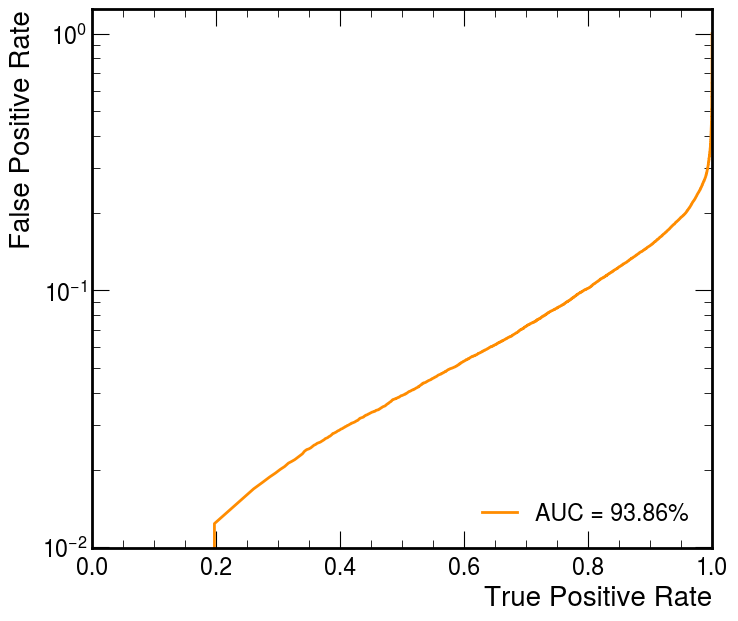

In [22]:
plt.rcParams.update({"font.size": 20})
make_roc(y_test, y_score, 'roc_rescl_rotate_transl_norm',save_flag=False)